In [1]:
# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
import pyspark
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, BooleanType, ArrayType, StringType, MapType, FloatType

#Spark NLP
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# Helpers
import os
from empath import Empath

In [2]:
conf = pyspark.SparkConf().setMaster("local[*]").setAll([
    ('spark.driver.memory','16G'),
    ('spark.driver.maxResultSize', '8G'),
    ('spark.sql.execution.arrow.pyspark.enabled', True),
    ('spark.local.dir', '/media/maculjak/2e9080dc-73f3-426f-a054-a46f620aea95/tmp')
])

spark = SparkSession.builder.config(conf=conf).config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.2").getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark


21/11/12 20:21:09 WARN Utils: Your hostname, aventinus resolves to a loopback address: 127.0.1.1; using 192.168.1.118 instead (on interface wlp5s0)
21/11/12 20:21:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/maculjak/anaconda3/envs/ada/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/maculjak/.ivy2/cache
The jars for the packages stored in: /home/maculjak/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8643f3c7-0e73-480f-b96f-817c1f223145;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;3.3.2 in central
	found com.typesafe#config;1.4.1 in central
	found org.rocksdb#rocksdbjni;6.5.3 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.603 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#

In [3]:
DATA_DIR = 'data/'
QUOTEBANK_DATA_DIR = DATA_DIR + 'quotebank_data/'

In [ ]:
dfs = []

for i in os.listdir(QUOTEBANK_DATA_DIR):
    dfs.append(spark.read.json(QUOTEBANK_DATA_DIR + i))

In [15]:
df = dfs[0]
for df_part in dfs[1:]:
    df = df.union(df_part)

In [73]:
df = spark.read.parquet(DATA_DIR + 'qb_data.parquet')

## Sentiment analysis with SparkNLP

In [8]:
# Loading the model
pipeline = PretrainedPipeline('analyze_sentiment', lang='en')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


In [ ]:
# Calculating sentiments of the quotes. We will select only the quoteID, sentiment, and classifier confidence so that the sentiments can be joined with other data.
sentiment = pipeline.fullAnnotate(df.where(f.col('date').rlike('^2020')), column='quotation')\
                    .select('quoteID',
                            f.col('sentiment.result').getItem(0).alias('sentiment'),
                            f.col('sentiment.metadata').getItem(0).confidence.alias('confidence'))

# Save sentiment sentiment scores for 2020 data so that they don't have to be recomputed
sentiment.write.parquet('data/2020-sentiments.parquet')

# It took ~43 minutes to calculate sentiments for the 2020 data. For the entire data it would then take ~16 hours, which is doable.

In [68]:
sentiment = spark.read.parquet('data/2020-sentiments.parquet')

# Join the datasets
df = df.join(sentiment, on='quoteID')

In [ ]:
# Overall sentiment distribution
sentiment_counts = df.groupby('sentiment').count().toPandas()

<AxesSubplot:title={'center':'Overall sentiment distribution'}, xlabel='sentiment', ylabel='count'>

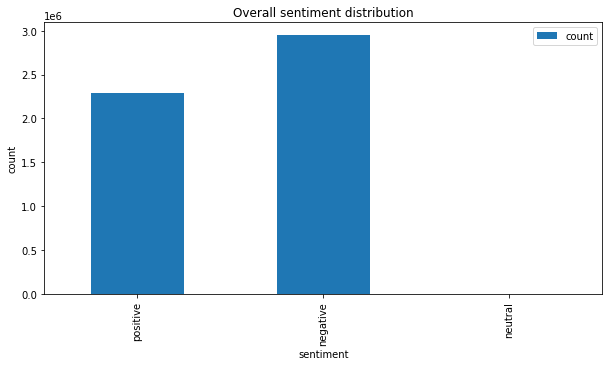

In [64]:
sentiment_counts.loc[sentiment_counts['sentiment'] == 'na', 'sentiment'] = 'neutral'
sentiment_counts.plot.bar(x='sentiment', y='count', figsize=[10, 5], title='Overall sentiment distribution', ylabel='count')

'na' sentiment actually corresponds to the situation where the classifier is confident neither in positive nor negative sentiment. Here we refer to it is neutral, but as it can be seen, this portion is rather small. Currently, by default, the classifier assigns 'na' label only when its confidence is zero (as it can be seen below) so the overall distribution may change if we decide to use some higher confidence threshold. 

In [66]:
df.where((f.col('confidence') < 1e-6)).groupby('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|       na| 3390|
+---------+-----+



In [171]:
# Count quotes with positive and negative sentiment for each speaker
speaker_sentiments = df.where(f.col('speaker') != 'None')\
                        .groupby('speaker', 'sentiment')\
                        .agg(f.count('quoteID').alias('count'))\
                        .toPandas()

# Counts -> percenages per speaker
speaker_sentiments.head()

,speaker,sentiment,count
0,Veng Sakhon,negative,7
1,Amarinder Singh,negative,395
2,Lynn Hamilton,negative,23
3,Reilly Smith,negative,32
4,Christian Diaz,negative,7


In [7]:
def replace_value(df, column, value_old, value_new):
    """Replaces a given value in a given column of a dataframe with a new one"""
    df.loc[df[column] == value_old, column] = value_new
    return df

# Calculate average sentiments
speaker_sentiments = replace_value(speaker_sentiments, 'sentiment', 'positive', 1)
speaker_sentiments = replace_value(speaker_sentiments, 'sentiment', 'negative', -1)
speaker_sentiments = replace_value(speaker_sentiments, 'sentiment', 'na', 0)

speaker_sentiments.head()

In [183]:
# We are only considering the speakers with 1000 or more quotes
more_than_1000_speakers = set([i.speaker for i in df.groupby('speaker')
                                                   .agg(f.count('quoteID').alias('count'))
                                                   .where(f.col('count') >= 1000).collect()])

In [196]:
# Computing average sentiment for each speaker
speaker_sentiments = speaker_sentiments[speaker_sentiments['speaker'].isin(more_than_1000_speakers)]
speaker_sentiments['sentiment_sum'] = speaker_sentiments['sentiment'] * speaker_sentiments['count']
value_sums = speaker_sentiments.groupby('speaker').sum(0)
average_sentiments = value_sums['sentiment_sum'] / value_sums['count']

most_negative = average_sentiments.nsmallest(10)
most_positive = average_sentiments.nlargest(10)

In [197]:
most_negative

speaker
Nick Nurse        -0.306852
Jimmy Kimmel      -0.261181
Piers Morgan      -0.248230
Stephen Colbert   -0.247863
Rush Limbaugh     -0.246301
Jim Cramer        -0.236842
Francisco Duque   -0.236111
Tucker Carlson    -0.234508
William Barr      -0.220322
Pope Francis      -0.214615
dtype: float64

In [198]:
most_positive

speaker
Selena Gomez          0.041769
Dwyane Wade           0.039537
Virat Kohli          -0.001448
Rafael Nadal         -0.001946
Demi Lovato          -0.026170
Tom Steyer           -0.027656
Gladys Berejiklian   -0.028571
Jessica Simpson      -0.031161
Billie Eilish        -0.036806
Taylor Swift         -0.044223
dtype: float64

In [10]:
@f.udf(StringType())
def get_month(date_str):
    return "-".join(date_str.split("-")[:2])

@f.udf(StringType())
def get_date(date_str):
    return "-".join(date_str.split("-")[:3])

def normalize_sentiment(key, pdf):
    pdf = replace_value(pdf, 'sentiment', 'positive', 1)
    pdf = replace_value(pdf, 'sentiment', 'negative', -1)
    pdf = replace_value(pdf, 'sentiment', 'na', 0)
    
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.sentiment.mean() ], "sem" : [ pdf.sentiment.sem() ]})

In [12]:
# Moving average of sentiment
sentiment_through_time = df \
        .select('quoteID', 'sentiment')\
        .withColumn('date', get_date(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize_sentiment, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas() \
        .set_index('key')

In [13]:
mavg = sentiment_through_time.rolling(14).mean()

/home/maculjak/anaconda3/envs/ada/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)


AttributeError: 'function' object has no attribute 'vline'

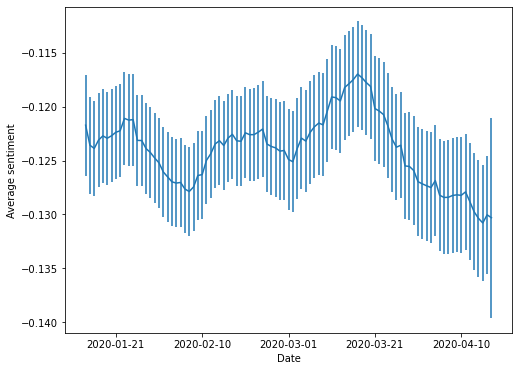

In [84]:
plt.figure(figsize=(8, 6))
mavg['mean'].plot.line(yerr=mavg['sem'], ylabel='Average sentiment', xlabel='Date')
plt.plot.vline('2020-03-21')

# EMPATH
Here we simply analyze whether it is feasible to use EMPATH.

In [69]:
lexicon = Empath()
get_aggression = f.udf(lambda x: lexicon.analyze(x, categories=['aggression'], normalize=True)['aggression'], FloatType())

In [80]:
aggressions = df.where(f.col('date').rlike('^2020'))\
                       .select('quoteID', get_aggression(f.col('quotation')).alias('aggression')) # Get aggression scores
aggressions.write.parquet('data/2020-aggression.parquet') # Save the data to memory

# Assigning aggression scores on the 2020 data took only ~2 minutes, which means it would take ~46 minutes for the entire data, which is fine.
# However it is important to note that this number will be multiplied by the number of categories that we opt for.

In [81]:
# Load aggression scores
aggressions = spark.read.parquet('data/2020-aggression.parquet')

In [92]:
def normalize_sentiment(key, pdf):
    pdf = replace_value(pdf, 'aggression', 'positive', 1)
    pdf = replace_value(pdf, 'aggression', 'negative', -1)
    pdf = replace_value(pdf, 'aggression', 'na', 0)
    
    return pd.DataFrame({"key": [ key[0] ], "mean" : [ pdf.aggression.mean() ], "sem" : [ pdf.aggression.sem() ]})

In [95]:
# A simple plot of aggression through time
ggression_through_time = aggressions \
        .select('quoteID', 'aggression')\
        .withColumn('date', get_date(f.col('quoteID'))) \
        .groupby('date') \
        .applyInPandas(normalize_sentiment, schema="key string, mean double, sem double") \
        .sort("key") \
        .toPandas() \
        .set_index('key')

/home/maculjak/anaconda3/envs/ada/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1061: UserWarning: Warning: converting a masked element to nan.
  x = np.asanyarray(x)


<AxesSubplot:xlabel='Date', ylabel='Average aggression'>

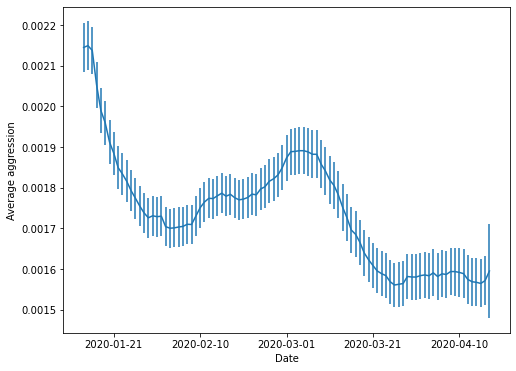

In [96]:
mavg = aggression_through_time.rolling(14).mean()

plt.figure(figsize=(8, 6))
mavg['mean'].plot.line(yerr=mavg['sem'], ylabel='Average aggression', xlabel='Date')

In [106]:
def url_list_to_tlds(urls):
    if urls is None or len(urls) == 0:
        return None
    res = list(map(lambda url : tldextract.extract(url).domain, urls))
    return res if res else None


In [ ]:
# Top 20 most frequent domains. The number may seem high, but this is becauase the same quote can appear in multiple articles.
domain_counts = df.where(f.col('date').rlike('^2020'))\
                .select(f.explode(f.udf(url_list_to_tlds, ArrayType(StringType()))(f.col('urls'))).alias('tld'))\
                .groupby('tld')\
                .count()\
                .sort('count', ascending=False)\
                .show()